In [88]:
import re
import pandas as pd
import glob
from pathlib import Path
from datetime import datetime
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame

# Configuration - Update 'logs_dir' to point to your data
logs_dir = '.'
output_csv = 'timing_analysis.csv'
output_speedup_csv = 'speedup_analysis.csv'

In [43]:
def parse_filename(filename):
    """Extract parameters from log filename using regex."""
    pattern = r'exec_timings_(?P<placement>pack|scatter)_np(?P<np>\d+)_threads_(?P<threads>\d+)_iter(?P<iter>\d+)_pop(?P<pop>\d+)_feat(?P<feat>\d+)\.log'
    match = re.match(pattern, filename)

    if match:
        return {
            'placement': match.group('placement'),
            'np': int(match.group('np')),
            'threads': int(match.group('threads')),
            'iterations': int(match.group('iter')),
            'population': int(match.group('pop')),
            'features': int(match.group('feat'))
        }
    else:
        pattern = r'exec_timings_(?P<placement>pack|scatter)_np(?P<np>\d+)_iter(?P<iter>\d+)_pop(?P<pop>\d+)_feat(?P<feat>\d+)\.log'

        match = re.match(pattern, filename)

        return {
            'placement': match.group('placement'),
            'np': int(match.group('np')),
            'threads': 1,
            'iterations': int(match.group('iter')),
            'population': int(match.group('pop')),
            'features': int(match.group('feat'))
        }

def extract_timings(log_path):
    """Extract total_time and computation_time from a log file content."""
    timings = {}
    try:
        with open(log_path, 'r') as f:
            content = f.read()

        # Extract Gather time
        gather_match = re.search(r'gather_all:\s+([\d.]+)', content)
        gather_time = float(gather_match.group(1)) if gather_match else 0
        timings['gather_time'] = gather_time

        # Extract and adjust total_time
        total_match = re.search(r'total_time:\s+([\d.]+)', content)
        if total_match:
            timings['total_time'] = float(total_match.group(1)) - gather_time

        # Extract and adjust computation_time
        comp_match = re.search(r'computation_time:\s+([\d.]+)', content)
        if comp_match:
            timings['computation_time'] = float(comp_match.group(1)) - gather_time

        return timings if timings else None
    except Exception as e:
        print(f"Error reading {log_path}: {e}")
        return None

In [65]:
# Adjust the pattern to match your directory structure accurately
file_pattern = "./serial/execution*/pbs/output/rra_tserial_e*_*"

data = []

# Regex for the log line: pop_size=128, features=100, iter=1000
params_regex = re.compile(r"pop_size=(\d+), features=(\d+), iter=(\d+)")
# Regex for the timestamp
time_regex = re.compile(r"\[(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})\]")

for filepath in glob.glob(file_pattern):
    # Extracting trial/execution/np/placement from filename
    # Assuming filename: rra_tserial_e<trial>_<placement>_np<np>
    # And directory: execution<num>
    path_parts = filepath.split('/')
    exec_match = re.search(r'execution(\d+)', filepath)
    file_match = re.search(r'rra_tserial_e(\d+)_([a-zA-Z]+)_np(\d+)', path_parts[-1])

    if file_match and exec_match:
        trial = int(file_match.group(1))
        placement = file_match.group(2)
        np_val = int(file_match.group(3))
        execution_id = int(exec_match.group(1))

        with open(filepath, 'r') as f:
            lines = f.readlines()
            content = "".join(lines)

            # Extract simulation parameters from the second line (usually)
            params = params_regex.search(content)
            # Extract all timestamps
            timestamps = time_regex.findall(content)

            if params and timestamps:
                dt_objects = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in timestamps]
                total_time = (max(dt_objects) - min(dt_objects)).total_seconds()

                data.append({
                    'placement': placement,
                    'population': int(params.group(1)),
                    'features': int(params.group(2)),
                    'iterations': int(params.group(3)),
                    'np': np_val,
                    'trial': trial,
                    'execution': execution_id,
                    'total_time': total_time
                })

# Create DataFrame
serial = pd.DataFrame(data)

# Sort based on your requirements
sort_columns = ['placement', 'population', 'features', 'iterations', 'np', 'trial', 'execution', 'total_time']
serial = serial.sort_values(sort_columns).reset_index(drop=True)

In [44]:
data = []
logs_path = Path(logs_dir)

# Find all .log files in the trial/execution structure
for log_file in logs_path.glob('trial*/execution*/output/*.log'):
    # Extract trial and execution numbers from path
    parts = log_file.parts
    trial_dir = next((p for p in parts if p.startswith('trial')), None)
    execution_dir = next((p for p in parts if p.startswith('execution')), None)

    trial_num = int(re.search(r'trial(\d+)', trial_dir).group(1)) if trial_dir else None
    execution_num = int(re.search(r'execution(\d+)', execution_dir).group(1)) if execution_dir else None

    # Parse filename and timings
    params = parse_filename(log_file.name)
    timings = extract_timings(log_file)

    if params and timings:
        record = {**params, **timings, 'trial': trial_num, 'execution': execution_num}
        data.append(record)
    else:
        print(f"Skipping or failed to parse: {log_file}")

# Create and clean DataFrame
df = pd.DataFrame(data)
if not df.empty:
    df = df.sort_values(['placement', 'population', 'features', 'iterations', 'np', 'trial', 'execution'])
    df.to_csv(output_csv, index=False)
    print(f"Successfully processed {len(df)} log files.")
else:
    print("No data found!")

df.head()

Successfully processed 226 log files.


,placement,np,threads,iterations,population,features,gather_time,total_time,computation_time,trial,execution
1,pack,1,1,1000,128,100,0.000000,237.089824,237.047385,0,1
14,pack,1,1,1000,128,100,0.000000,234.877386,234.869571,0,2
27,pack,1,1,1000,128,100,0.000000,235.194335,235.188263,0,3
40,pack,1,1,1000,128,100,0.000103,244.998682,244.983950,1,1
52,pack,1,1,1000,128,100,0.000103,239.033005,239.024359,1,2


In [57]:
# Grouping by 'np' and 'placement' and calculating the mean
trial0 = df[df["trial"] == 0]
trial1 = df[df["trial"] == 1]
trial1["total_time"] = trial1["total_time"] - trial1["gather_time"]
trial2 = df[df["trial"] == 2]
trial3 = df[df["trial"] == 3]

In [66]:
# Display the result
summary_table = serial.groupby(['np', 'placement'])[['total_time']].mean().reset_index()
summary_table0 = trial0.groupby(['np', 'placement'])[['total_time', "computation_time"]].mean().reset_index()
summary_table1 = trial1.groupby(['np', 'placement'])[['total_time', "computation_time"]].mean().reset_index()
summary_table2 = trial2.groupby(['np', 'placement'])[['total_time', "computation_time"]].mean().reset_index()
summary_table3 = trial3.groupby(['np', 'placement', 'threads'])[['total_time', "computation_time"]].mean().reset_index()

In [68]:
print(summary_table)
print(summary_table0)
print(summary_table1)
print(summary_table2)
print(summary_table3)

    np placement  total_time
0    1      pack  195.000000
1    1   scatter  195.333333
2    2      pack  192.000000
3    2   scatter  195.000000
4    4      pack  191.333333
5    4   scatter  196.333333
6   16      pack  193.000000
7   16   scatter  210.000000
8   32      pack  210.333333
9   32   scatter  210.666667
10  64      pack  262.000000
11  64   scatter  211.333333
     np placement  total_time  computation_time
0     1      pack  235.720515        235.701740
1     1   scatter  213.172530        213.156566
2     2      pack  214.206540        214.194104
3     2   scatter  179.496499        179.482995
4     4      pack  214.612128        214.592038
5     4   scatter  190.690851        190.669642
6    16      pack  242.625676        242.615402
7    16   scatter  214.253177        214.243085
8    32      pack  245.400891        245.387901
9    32   scatter  228.135850        228.117588
10   64      pack  219.504485        219.480110
11   64   scatter  259.981063        259.967921

In [69]:
# 1. Prepare the Baseline
# Rename columns to avoid confusion during merge
baseline = summary_table.rename(columns={'total_time': 'baseline_time'})

# 2. Define the Speedup Calculation Logic
def calculate_implementation_speedup(target_df, label):
    # Join with baseline on np and placement
    merged = pd.merge(target_df, baseline, on=['np', 'placement'], how='left')

    # Calculate speedup using computation_time (removing MPI overhead)
    merged[f'speedup_{label}'] = merged['baseline_time'] / merged['computation_time']
    return merged

# 3. Compute Speedups for all trials
# Trial 0
results0 = calculate_implementation_speedup(summary_table0, 'trial0')

# Trial 1
results1 = calculate_implementation_speedup(summary_table1, 'trial1')

# Trial 2
results2 = calculate_implementation_speedup(summary_table2, 'trial2')

# Trial 3 (MPI + OpenMP Hybrid)
results3 = calculate_implementation_speedup(summary_table3, 'trial3')

In [70]:
results0.head(5)

,np,placement,total_time,computation_time,baseline_time,speedup_trial0
0,1,pack,235.720515,235.701740,195.000000,0.827317
1,1,scatter,213.172530,213.156566,195.333333,0.916384
2,2,pack,214.206540,214.194104,192.000000,0.896383
3,2,scatter,179.496499,179.482995,195.000000,1.086454
4,4,pack,214.612128,214.592038,191.333333,0.891614


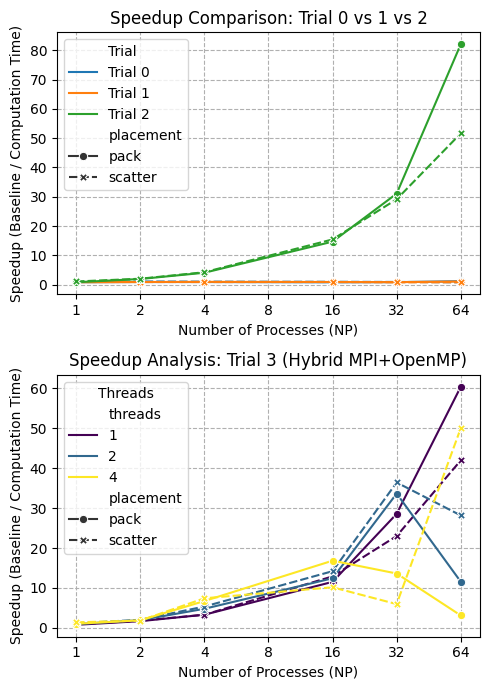

In [90]:
# Combine for Plotting
results0['Trial'] = 'Trial 0'; results0['Speedup'] = results0['speedup_trial0']
results1['Trial'] = 'Trial 1'; results1['Speedup'] = results1['speedup_trial1']
results2['Trial'] = 'Trial 2'; results2['Speedup'] = results2['speedup_trial2']

df_comparison = pd.concat([
    results0[['np', 'placement', 'Trial', 'Speedup']],
    results1[['np', 'placement', 'Trial', 'Speedup']],
    results2[['np', 'placement', 'Trial', 'Speedup']]
], ignore_index=True)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(5, 7))

# Plot 1: Comparison of Trial 0 vs 1 vs 2
sns.lineplot(data=df_comparison, x='np', y='Speedup', hue='Trial', style='placement', markers=True, ax=axes[0])
axes[0].set_title('Speedup Comparison: Trial 0 vs 1 vs 2')
axes[0].set_xscale('log', base=2)
axes[0].set_ylabel('Speedup (Baseline / Computation Time)')
axes[0].set_xlabel('Number of Processes (NP)')
axes[0].grid(True, which="both", ls="--")

# Plot 2: Trial 3 (Focus on Threads)
# Ensure clean index for plotting
results3 = results3.reset_index(drop=True)
sns.lineplot(data=results3, x='np', y='speedup_trial3', hue='threads', style='placement', palette='viridis', markers=True, ax=axes[1])
axes[1].set_title('Speedup Analysis: Trial 3 (Hybrid MPI+OpenMP)')
axes[1].set_xscale('log', base=2)
axes[1].set_ylabel('Speedup (Baseline / Computation Time)')
axes[1].set_xlabel('Number of Processes (NP)')
axes[1].legend(title='Threads')
axes[1].grid(True, which="both", ls="--")

# --- Modifying X-Axis to show integers instead of powers of 2 ---
ticks = [1, 2, 4, 8, 16, 32, 64]

for ax in axes:
    ax.set_xscale('log', base=2)
    ax.set_xticks(ticks)
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    # Optional: Clear minor ticks to avoid confusion
    ax.minorticks_off()

plt.tight_layout()
plt.savefig('speedup_analysis.png')

In [104]:
def parse_convergence_filename(filename):
    """Extract parameters from convergence CSV filename."""
    # Pattern handles the specific naming convention of the convergence files
    pattern = r'convergence_results_(?P<placement>\w+)_np(?P<np>\d+)_threads(?P<threads>\d+)_iter(?P<iter>\d+)_pop(?P<pop>\d+)_feat(?P<feat>\d+)\.csv'
    match = re.search(pattern, filename)

    if match:
        return {
            'placement': match.group('placement'),
            'np': int(match.group('np')),
            'threads': int(match.group('threads')),
            'iterations': int(match.group('iter')),
            'population': int(match.group('pop')),
            'features': int(match.group('feat'))
        }
    else:
        pattern = r'convergence_results_(?P<placement>\w+)_np(?P<np>\d+)_iter(?P<iter>\d+)_pop(?P<pop>\d+)_feat(?P<feat>\d+)\.csv'
        match = re.search(pattern, filename)

        return {
            'placement': match.group('placement'),
            'np': int(match.group('np')),
            'threads': 1,
            'iterations': int(match.group('iter')),
            'population': int(match.group('pop')),
            'features': int(match.group('feat'))
        }

# Target directories
folders = ['final', 'openmp']
all_convergence_data = []

for folder in folders:
    base_path = Path(folder)
    # Search for convergence CSVs in the trial/execution/output structure
    for csv_file in base_path.glob('output/convergence_results_*.csv'):

        # 1. Extract metadata from path (Trial and Execution)
        parts = csv_file.parts
        exec_dir = next((p for p in parts if p.startswith('execution')), "execution0")

        exec_num = int(re.search(r'\d+', exec_dir).group())

        # 2. Extract metadata from filename
        params = parse_convergence_filename(csv_file.name)

        if params:
            try:
                # 3. Read the CSV content
                temp_df = pd.read_csv(csv_file, on_bad_lines='skip')

                # If the file was empty or header-only after skipping
                if temp_df.empty:
                    continue

                # Add metadata columns to every row in this specific CSV
                for key, value in params.items():
                    temp_df[key] = value

                temp_df['trial'] = folder
                temp_df['execution'] = exec_num
                temp_df['source_folder'] = folder # Keep track of 'final' vs 'openmp'

                all_convergence_data.append(temp_df)
            except Exception as e:
                print(f"Error processing {csv_file}: {e}")

# Combine all individual files into one large DataFrame
if all_convergence_data:
    convergence_df = pd.concat(all_convergence_data, ignore_index=True)

    # Optional: Sort by iterations and rank to keep it readable
    convergence_df = convergence_df.sort_values(
        ['source_folder', 'placement', 'np', 'trial', 'execution', 'iteration', 'rank']
    )
    print(f"Successfully processed {len(convergence_df)} total rows.")
else:
    print("No convergence data found!")

# Preview the results
print(convergence_df.head())

Successfully processed 3718193 total rows.
        iteration  rank    fitness  timestamp  local_best_idx  \
508383        0.0   0.0   7.510845   0.196903           960.0   
524383        0.0   0.0   7.166588   0.346200             0.0   
540383        0.0   0.0   7.128587   0.057618           192.0   
556383        0.0   0.0  14.846904   0.087343           128.0   
509383        0.0   1.0   7.510845   0.196903           960.0   

        global_best_fitness  improvement placement  np  threads  iterations  \
508383          4888.795922  4881.285076   scatter  16        1        1000   
524383          4697.771855  4690.605268   scatter  16        1        1000   
540383          5004.498608  4997.370020   scatter  16        1        1000   
556383          4974.073555  4959.226651   scatter  16        1        1000   
509383          4888.795922  4881.285076   scatter  16        1        1000   

        population  features  trial  execution source_folder  
508383        1024       200

In [131]:
mpi = convergence_df[convergence_df["source_folder"] == 'final']
openmp = convergence_df[convergence_df["source_folder"] == 'openmp']

def get_convergence_info(group):
    # Find the absolute best fitness achieved in this specific run
    best_val = group['global_best_fitness'].min()
    # Find the first time this value was reached
    convergence_row = group[group['global_best_fitness'] == best_val].iloc[0]

    return pd.Series({
        'conv_timestamp': convergence_row['timestamp'],
        'final_fitness': best_val
    })

group_cols = ['placement', 'np', 'population']
convergence_mpi = mpi.groupby(group_cols).apply(get_convergence_info).reset_index()
group_cols = ['placement', 'np', 'threads' ,'population']
convergence_openmp = openmp.groupby(group_cols).apply(get_convergence_info).reset_index()

               NP_16     NP_32     NP_64    NP_128
population                                        
256         0.118871  0.053318  0.034862  0.039620
512         0.193705  0.099736  0.065045  0.033698
1024        0.382867  0.208909  0.124325  0.084055
2048        0.702385  0.433414  0.228745  0.121879


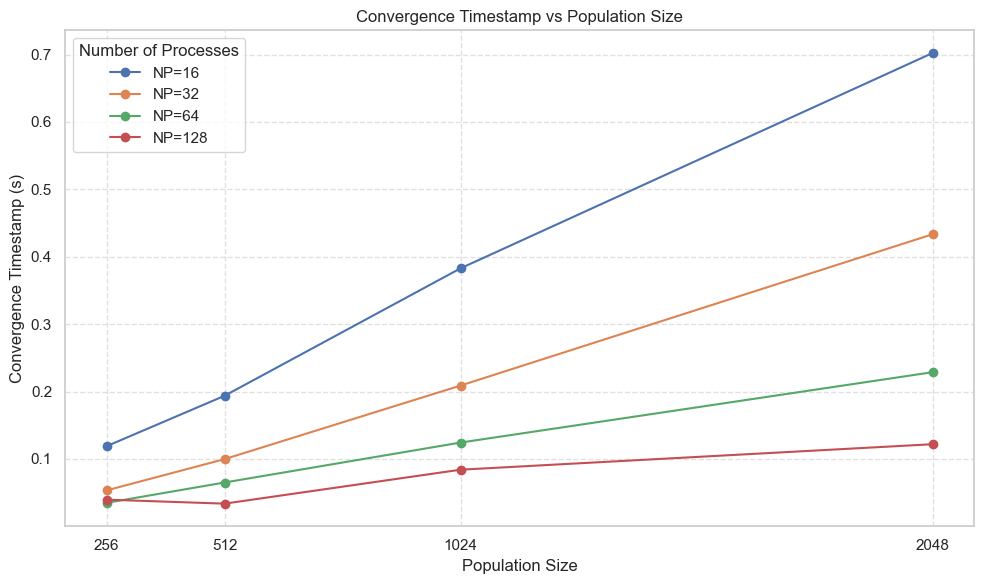

In [140]:
sns.set_theme(style="whitegrid")

pivot_df = convergence_mpi.pivot(index='population', columns='np', values='conv_timestamp')
pivot_df.columns = [f'NP_{c}' for c in pivot_df.columns]
pivot_df.to_csv('convergence_summary_table.csv')
print(pivot_df)

# 3. Create the Single Graph
plt.figure(figsize=(10, 6))
nps = sorted(convergence_mpi['np'].unique())

for np_val in nps:
    subset = convergence_mpi[convergence_mpi['np'] == np_val].sort_values('population')
    plt.plot(subset['population'], subset['conv_timestamp'],
             marker='o', linestyle='-', label=f'NP={np_val}')

plt.title('Convergence Timestamp vs Population Size')
plt.xlabel('Population Size')
plt.ylabel('Convergence Timestamp (s)')
plt.legend(title='Number of Processes')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(convergence_mpi['population'].unique())
plt.tight_layout()
plt.savefig('mpi_conv.png')

--- OpenMP Multi-Thread Summary Table ---
np  population  threads          16          32          64          128
0          256        2    0.070989    0.053748    0.055633     1.339995
1          256        4    0.082591    0.271876    1.257366     0.592873
2          256        6    0.185460    1.706021    0.962248     1.512920
3          512        2   32.959177   30.765450   25.106467     9.879876
4          512        4   71.164031   27.988846   47.032793   191.481383
5          512        6  213.021975  161.711716  465.391217   121.268412
6         1024        2  110.595377   16.739376  114.144212    57.157268
7         1024        4   42.497601   16.000000    0.379990    50.026594
8         1024        6  423.245559   43.593452  493.489927   180.211508
9         2048        2  207.798104  117.758792  107.511012  1548.000000
10        2048        4  115.881928  274.141117   45.884551   250.405545
11        2048        6   81.237932  103.232637   83.771846   354.849357


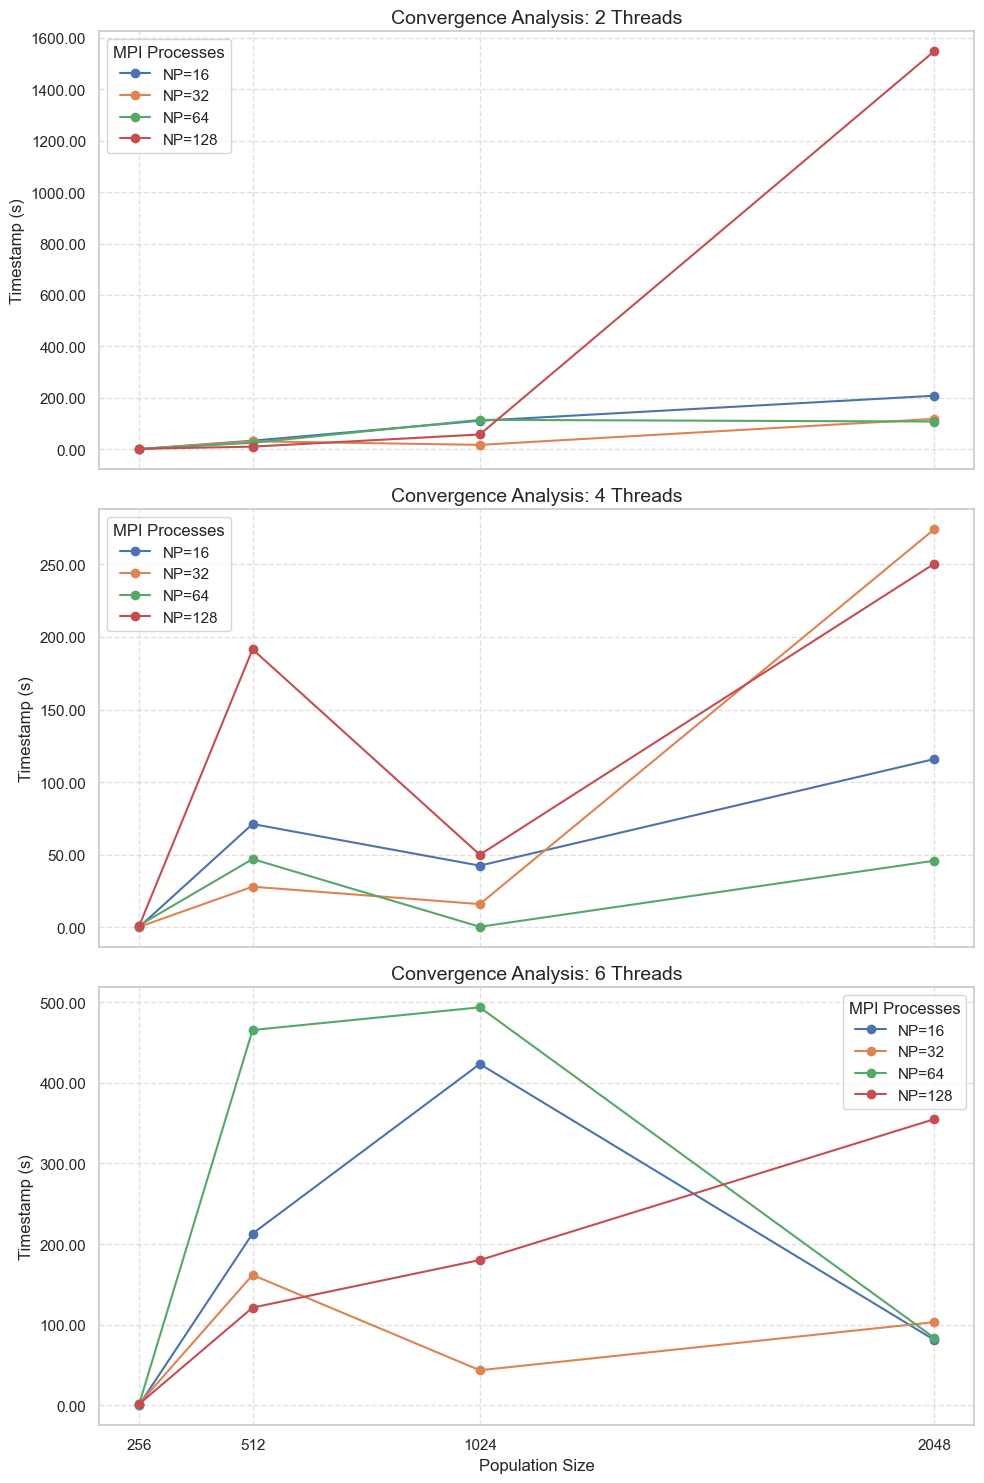

In [147]:
# 1. Pivot the data to maintain the joined table format
# index=['population', 'threads'] keeps the numbers paired correctly
pivot_table = convergence_openmp.pivot_table(
    index=['population', 'threads'],
    columns='np',
    values='conv_timestamp'
).reset_index()

print("--- OpenMP Multi-Thread Summary Table ---")
print(pivot_table)

# 2. Generate 3 Graphs (1 per thread count)
threads_list = sorted(convergence_openmp['threads'].unique())
fig, axes = plt.subplots(len(threads_list), 1, figsize=(10, 15), sharex=True)

for i, t_val in enumerate(threads_list):
    ax = axes[i]
    # Filter for the specific thread count
    thread_data = convergence_openmp[convergence_openmp['threads'] == t_val]

    # Plot a line for each NP configuration
    for np_val in sorted(thread_data['np'].unique()):
        subset = thread_data[thread_data['np'] == np_val].sort_values('population')
        ax.plot(subset['population'], subset['conv_timestamp'],
                marker='o', label=f'NP={np_val}')

    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.set_title(f'Convergence Analysis: {t_val} Threads', fontsize=14)
    ax.set_ylabel('Timestamp (s)')
    ax.legend(title='MPI Processes')
    ax.grid(True, linestyle='--', alpha=0.6)

# Final formatting
axes[-1].set_xlabel('Population Size')
plt.xticks(convergence_openmp['population'].unique())
plt.tight_layout()
plt.savefig('openmp_conv.png')